Introduction: Here I will be constructing a jupyter notebook that will compute the spectral evolution of a spreading
annulus of gaseous mass orbiting a central mass, representative of a black hole in this case. The spreading annulus is representative
of a one dimensional accretion disk model, and my motivation behind this idea is to
understand how accretion disks change over time, both dynamically and in terms of the
radiation they emit. The equations are developed and shown from Pringle 1981.

This cell will import the necessary libraries such as numpy, scipy (with special functions), and matplotlib, as well as some tools to help visualize how my plots change with certain varied parameters.

In [149]:
import numpy as np
from numpy import *
import scipy
from matplotlib import pyplot as plt
from scipy import special
from ipywidgets import interact, interactive
import ipywidgets as widgets

I now define variables for the physical constants I will be using in cgs units, such as the universal gravitaional constant, the speed of light, the Stefan Boltzman constant, Planck's constant,  and the salpeter time (defined as the timescale for black hole growth assuming accretion does not exceed the Eddington limit).

In [150]:
GM = 1.0
Rstar = 1.0
G = 6.67e-8  # cm^3 g^-1 s^-2
Msun = 2e33  # g
sb = 5.67e-5  # g s^-3 K^-4: Stefan Boltzman Constant in cgs
c = 3e10  # cm s^-1
h = 6.626e-27  # ergs s: Planck's Constant in cgs
k = 1.38e-16  # ergs K^-1
year = 3.15e7 # s
tsal = 5e7 * year # s: salpeter time
erg = 6.242e11  # eV

The following few cells will define relatively simple functions of radius to set up the physics of the spreading annulus of gaseous matter in a keplarian orbit.

For now, I consider a gaseous disk with a constant kinematic viscosity.

In [151]:
def kinematic_viscosity(R):
    return 1e-1


def kinematic_viscosity_derivative(R):
    return 0.0


Because of the nature of the disk's orbit, the circular velocity of the disk is keplarian, and given by:

In [152]:
def keplerian_omega_log_derivative(R):
    """
    Return the shear profile d(Omega) / d(log R)
    """
    return -1.5 * sqrt(GM / R**3)


def keplerian_omega(R):
    return sqrt(GM / R**3)


The specific angular momentum of the disk is:

In [153]:
def specific_angular_momentum(R):
    return sqrt(GM * R)


def specific_angular_momentum_derivative(R):
    return 0.5 * sqrt(GM / R)


The surface density at one single radius in the disk is:

In [154]:
def sigma(M, R):
    """
    Return the surface density at a paticular radius
    """
    return M / (pi * diff(R**2))

And the radial velocity of the disk, Vr, can be obtained with the surface density, kinematic viscosity, and the derivatives of the circular velocity and the the angular momentum.

In [155]:
def radial_velocity(M, R):
    """
    Return the radial gas velocity at the internal zone interfaces

    v = d/dR(R g) / (sigma R l')
    """
    Rc = 0.5 * (R[1:] + R[:-1])
    s = sigma(M, R)
    n = kinematic_viscosity(Rc)
    A = keplerian_omega_log_derivative(Rc)
    g = Rc * s * n * A
    m = specific_angular_momentum_derivative(R[1:-1])
    return diff(Rc * g) / diff(Rc) / (0.5 * (s[1:] + s[:-1]) * m * R[1:-1])

From these relatively simple equations, the analytic solution for the surface density over the whole disk as a function of mass, radius, and time is given by:

In [156]:
def surface_density(M, R, t):
    """
    Return the analytic solution for the surface density
    """
    m = 1.0
    Ri = 4.0
    n = kinematic_viscosity(R)
    tau = 12 * n * (Ri**-2) * t
    x = (R/Ri)
    return ((m/pi * Ri**2) * tau**(-1) * (x**(-1/4)) * exp(-(1+(x**2))/tau) * scipy.special.iv(0.25, 2 * x / tau))

Using a fluid dynamics approach, the mass flux is calculated by:

In [157]:
def godunov_fluxes(M, R, ret_torque=False):
    Mdot = 1.0

    R0 = R[:-1]
    R1 = R[+1:]

    Fhat = zeros_like(R)
    s = sigma(M, R)
    v_hat = radial_velocity(M, R)
    s_hat = (v_hat > 0.0) * s[:-1] + (v_hat < 0.0) * s[1:]
    Fhat[1:-1] = 2 * pi * R[1:-1] * s_hat * v_hat

    # Boundary conditions on the mass flux:
    Fhat[+0] = -Mdot
    Fhat[-1] = -Mdot

    if ret_torque:
        A = keplerian_omega_log_derivative(R)
        nu = kinematic_viscosity(R)
        Ghat = zeros_like(R)
        Ghat[1:-1] = -2 * pi * s_hat * (nu * A * R**2)[1:-1]
        return Fhat, Fhat * specific_angular_momentum(R), Ghat
    else:
        return Fhat


def time_derivative(M, R):
    Fhat = godunov_fluxes(M, R)
    return -diff(Fhat)

Finally, this next cell generates a visual depiction of the surface density of an accretion disk as a function of radius. This model begins as a "ring" of gaseous matter spreading into a disk. In accretion disks, most of the mass moves inward near the initial radius as time passes, losing energy and angular momentum. A tail of matter moves out to larger radii in an effort to "take up" the angular momentum. This is seen below, as I plot the surfce density as function of radius, with time varied. The effect is not all too dramatic, as in my example it occurs rather quickly, but it is noticeable here.

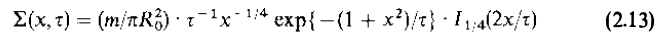

In [158]:
def set_plot(M, R, ax=None):
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    R0 = R[:-1]
    R1 = R[+1:]
    Rc = 0.5 * (R0 + R1)
    mdot, Jdot_adv, Jdot_vis = godunov_fluxes(M, R, ret_torque=True)
    v = radial_velocity(M, R)
    ax.set_xlabel(r"$R$")
    ax.legend()
    return ax


def plot_disk_surface_density(t:float):
    N = 1000
    R = linspace(2.0 * Rstar, 100.0 * Rstar, N + 1)
    dR = diff(R)
    R0 = R[:-1]
    R1 = R[+1:]
    Rc = 0.5 * (R0 + R1)
    dt = 0.1 * (dR**2 / kinematic_viscosity(R)).min()

    tfinal = 50.0
    s = 1.0
    M = s * pi * (R1**2 - R0**2)
    n = 0

    fig = plt.figure()
    ax = fig.add_subplot(111)

    if set_plot:
        set_plot(M, R, ax=ax)

    s1 = surface_density(M, R, t)
    ax.plot(R, s1, "-o", mfc="none", label=r"$\Sigma$ Numerical")

    while t < tfinal:
        K = time_derivative(M, R)
        M += K * dt
        t += dt
        n += 1

    if set_plot:
        set_plot(M, R, ax=ax)
        plt.title('Disk Surface Density')
        plt.xlim([0, 20])
        plt.ylim([0, 5.0])
        plt.show()

In [159]:
interact(plot_disk_surface_density,
  t = widgets.FloatSlider(value=10.0, min=0.1, max = 50, step=0.1, descriptions='time', disabled=False))

interactive(children=(FloatSlider(value=10.0, description='t', max=50.0, min=0.1), Output()), _dom_classes=('w…

<function __main__.plot_disk_surface_density(t: float)>

Directly from this, the luminosity of the steady disk will be calculated by integrating the dissipation rate over the disk from the center to the outer radius. Below, I plot luminosity from the disk alone vs. radius on a logarithmic scale. I also added a widget to vary the time, because the luminosity from the disk depends on the surface density of the disk, as seen in the last plot. However, because of how quickly the ring spreads into a disk, I interestingly found that the spreading of the ring does not impact the luminosity of the disk much at all.

In addition, this luminosity is of the disk itself, not from accretion on the boundary layer. The matter outside the boundary layer retains half of the potential energy that has been lost as kinetic energy! So what we see here from the disk alone is just a fraction of the accretion luminosity (Pringle 1981). Equation (3.11):


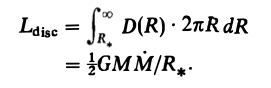

In [195]:
def plot_disk_luminosity(t: float):
    N = 1000
    R = np.linspace(2.0 * Rstar, 100.0 * Rstar, N + 1)
    dR = diff(R)
    Rl = R[:-1]
    Rf = R[+1:]
    Rc = 0.5 * (Rl + Rf)
    dt = 0.1 * (dR**2 / kinematic_viscosity(R)).min()
    s = 1.0
    M = s * pi * (Rf**2 - Rl**2)
    s1 = surface_density(M, R, t)

    #Vr = radial_velocity(M, R)
    # but for R >> Rstar,
    Vr = -3 * kinematic_viscosity(R) / (2 * R)
    Mdot = 2 * np.pi * R * s1 * -Vr

    L = 0.5 * G * M * Mdot[+1:] / Rstar
    nu_v = logspace(12, 19, 1000)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(Rc, nu_v*L, "-o", mfc="none")
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$R$')
    ax.set_ylabel(r'$\nu L_{\nu} \rm{[erg / s]}$')
    plt.title('Total Disk Luminosity')
    plt.show()

Expectedly, the luminosity peaks at smaller radii at earlier times. It spreads out over all radii over time. The luminosity of the disk itself, for the current given parameters, is not substantial.

In [196]:
interact(plot_disk_luminosity,
  t = widgets.FloatSlider(value=10.0, min=0.1, max = 50, step=0.1, descriptions='time', disabled=False))

interactive(children=(FloatSlider(value=10.0, description='t', max=50.0, min=0.1), Output()), _dom_classes=('w…

<function __main__.plot_disk_luminosity(t: float)>

The next cells begin calculations for the thermal spectrum of the disk, assuming it is an isothermal blackbody (optically thick). A disk temperature profile is derived from these conditions, and from this the spectrum emitted will be calcualted and plotted here.

Below are functions defining the accretion rate of the disk mass (using the Eddington accretion rate), as well as the radius of the inner most stable orbit around the central black hole (Schwarzschild radius):

In [162]:
def Mdot_acc(M, edd_frac):
  return edd_frac * M /tsal

def Risco(M):
  return 12 * G * M /c**2

From here, temperature profiles for the disk and the inner boundary edge of the disk are calculated, as well as the planck spectrum function because the accretion disk is modelled as a blackbody.

In [163]:
def disk_temperature(R: float, R0: float, M: float, Mdot: float):
    """
    The surface temperature of a steady-state disk with inner radius R0
    This is Eqn. 3.23 of Pringle (1981).
    """
    return Tstar(R0, M, Mdot) * ((R0 / R) ** 3 * (1 - sqrt(R0 / R))) ** 0.25


def Tstar(R0: float, M: float, Mdot: float):
    """
    The temperature of the inner edge of a steady-state accretion disk
    This equation appears below Eqn. 3.23 of Pringle (1981).
    """
    return (3 * G * M * Mdot / (8 * np.pi * R0**3 * sb)) ** 0.25


def planck_spectrum(T, nu):
    """
    The specific intensity of a blackbody of temperature T, and frequency nu.
    """
    return 2 * h * nu**3 / c**2 / (exp(h * nu / (k * T)) - 1)


Now, the spectrum of the single disk is calculated using the above functions, in short, it is the planck spectrum of the disk temperature. The calculation is performed using a first order integral over the radius of the disk (inner radius to outer radius) to produce the multi-temperature blackbody spectrum. Equation (3.25):

 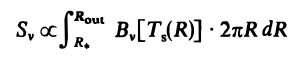

In [164]:
def disk_spectrum(M: float, Mdot: float, R0: float, R, delta: float = 0.1):
    """
    Produce a disk spectrum
    Uses a 1st-order integral over disk radius to produce the multi-temperature
    BB spectrum of a disk, which extends from R0 to Rout.
    Note: the frequency range is currently hard-coded. This should be fixed so
    that it has a sensible default range of frequencies.
    Note: multiply the result by pi to obtain the isotropic specific power
    Inu = integral of 2 * pi * R * dR * Bnu(T(R), nu) from R0 -> Rout
    """

    nu_v = logspace(12, 19, 999)
    nu_c = 0.5 * (nu_v[1:] + nu_v[:-1])
    R0 = Risco(M)
    Rout = 1000
    Inu = zeros_like(nu_c)

    if Rout < R0:
      print('Warning: Rout < R1, the spectrum is zero')

    while R < Rout:
      dR = R * delta
      Inu += 2 * pi * R * dR * planck_spectrum(disk_temperature(R, R0, M, Mdot), nu_c)
      R *= 1.0 + delta
    return nu_v, Inu

def plot_disk_spectrum(M, pref_acc, R, t):
    delta=0.001
    edd_frac = 1 / (1 + pref_acc)
    Mb = M * Msun # Mass of the central black hole in grams
    Mdot = Mdot_acc(Mb, 1.0) # Accretion rate of the black hole in g/s

    nu_v, Inu = disk_spectrum(M, Mdot, Risco(M), R, delta=0.001)
    nu_c = 0.5 * (nu_v[1:] + nu_v[:-1])
    Snu = pi * Inu * nu_c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(h * nu_c * erg, Snu, linewidth=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$h \nu \rm{[eV]}$')
    ax.set_ylabel(r'$S_{\nu} \rm{[erg / s]}$')
    ax.legend(loc='lower left')
    fig.tight_layout(pad=0.1)
    plt.show()

Below, widgets allow a viewer to adjust the mass of the disk, the accretion rate, the outer radius, and the time. Notice that varying the time truly does not change too much, becaus I found that the actual spread of the gaseous annulus is quite fast and does not have a significant effect on the overall spectrum emitted. So for this reason, I decided not to make a movie of the disk spectrum over time.

Notice that varying the mass of the disk has the most influence on the spectrum.

In [197]:
interact(plot_disk_spectrum,
  M = widgets.FloatSlider(value=1e7, min=1e6, max = 1e8, step=1e4, descriptions='Disk Mass [Msun]:', disabled=False),
  pref_acc = widgets.FloatSlider(value=10, min=1, max = 10, step=0.1, descriptions='Preferrential Accretion:', disabled=False),
  R = widgets.FloatSlider(value=10, min=1, max = 100, step=0.1, descriptions='Disk Thickness:'),
  t = widgets.FloatSlider(value=10.0, min=0.1, max = 10000, step=0.1, descriptions='time', disabled=False))

interactive(children=(FloatSlider(value=10000000.0, description='M', max=100000000.0, min=1000000.0, step=1000…

<function __main__.plot_disk_spectrum(M, pref_acc, R, t)>